# Convolutional Experimentation on Motor Imagery Data

### Thomas Peschlow | 40190020 | COMP432 | Final Project | Prof. Mirco Ravanelli | Winter 2024 | Concordia University

---

### Introduction

The following notebook includes custom implementations of neural networks meant to decode motor imagery using the [BNCI2014001](http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014_001.html#moabb.datasets.BNCI2014_001) dataset, with the help of the [speechbrain-MOABB](https://github.com/speechbrain/benchmarks/tree/main/benchmarks/MOABB) library. Each one of the following experiments were run on [RunPod.io](https://www.runpod.io/)'s JupyterLab infrastructure, using an Nvidia A40 and rtx A5000 GPUs.

**Important to note:** 

- As this notebook was not run using Google Colaboratory, details such as the folder for experimentation are not the same. While the default folder in Colab is /content, here it is /workspace/content.
- ipython extensions, such as %%capture, had to be installed manually.
- All training cells had to be muted with %%capture, as JupyterLab, unlike Colab, does not automatically cap the length of a cell's output. As such, the ever-increasing length of a cell's output would cause the web browser to eventually crash.

---
### Motivations

As you might have guessed, all of the experimentation done within the frame of this project was done on convolutional networks, a decision motivated by a few reasons: 
- Taking into consideration the potential use cases of motor imagery decoding, which include real time, continuous assitance of people with limited mobility, models with growing inference times, such as RNNs, LSTMs or transformers are not viable for such a task.
- Experimenting with architectures based on RNNs and LSTMs seems somewhat futile when considering that a similar, yet much more powerful architecture such as transformers has only yielded a best result about 5.5% inferior (EEGConformer, 67.5% accuracy) to the state of the art convolutional approach (EEGNet, 73% accuracy) on the dataset used for this experiment. [Benchmarks](https://github.com/speechbrain/benchmarks/tree/main/benchmarks/MOABB)
- While analyzing the different documented models, I was astounded by ShallowConvNet's performance on the dataset (69.5% accuracy) despite its extreme simplicity. Further analysis of its function showed how every single component was specifically tailored for EEG data,especiually highlighted by the spatial convolution being the exact size of the feature vector an EEG sampling provides, to avoiding typical non-linear functions such as ReLU, favouring a squaring layer which I assume is to highlight signal intensity without loss of information. Due to its simplicity and proven performance, it seemed to be the ideal starting point for building new models tailored to the same task.

# Prerequisites
---
- Includes necessary libraries, packages, and dependencies to run the following code. \
- Uses a personal fork of speechbrain, which I had used to fix a dependency issue that had arisen when mne updated to a newer, incompatible version. PR has since been merged. 
- Results can be downloaded from [Here](https://drive.google.com/drive/folders/1fsOpiTvNFrNyKbDXQjq-v5NzWAs8qjGX?usp=sharing), and placed in /workspace/results for plotting replication.

In [ ]:
# Only necessary if running in an environment other than colab
!pip install ipython-extensions

In [5]:
# Prerequisites for experimentation pipeline
%%capture
# Download SpeechBrain MOABB
%mkdir -p /workspace/content/
%cd /workspace/content/

!git clone https://github.com/CyWP/benchmarks
%cd /workspace/content/benchmarks/
!git checkout fix-deps

%cd /workspace/content/benchmarks/benchmarks/MOABB
!pip install -r extra-requirements.txt # Install additional dependencies

# Install SpeechBrain and SpeechBrain-MOABB requirements, and install SpeechBrain
# Clone SpeechBrain repository (development branch)
%cd /workspace/content/
!git clone https://github.com/speechbrain/speechbrain/
%cd /workspace/content/speechbrain/

# Install required dependencies
!pip install -r requirements.txt

# Install SpeechBrain in editable mode
!pip install -e .

%cd /workspace/content/benchmarks/benchmarks/MOABB

#Install BrainDecode and hyperpyyaml
!pip install braindecode

#Prerequisites for plotting and analysis
!pip install matplotlib
!pip install seaborn


UsageError: Line magic function `%%capture` not found.


In [ ]:
# Function used to plot subject-wise training and validation accuracy
import pathlib as pl
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

def plot_subject_accuracies(path: str, modelname:str):
    data = []
    for path in pl.Path(path).glob('**/*_metrics.pkl'):
        with open(path, 'rb') as f:
            metrics = pkl.load(f)
        parts = path.parts
        set_ = parts[-1].split('_')[0]
        session = parts[-2]
        subject = parts[-3]
        trial = parts[-7]
        seed = parts[-5]
        run = parts[-6]
        metrics.update(session=session, subject=subject, trial=trial, seed=seed, run=run, set=set_)
        data.append(metrics)
    data = pd.DataFrame(data)
    data = data.set_index([
        'trial', 'session', 'subject', 'set'
    ])
    valid = data.xs('valid', level='set')
    test = data.xs('test', level='set')
    data = valid.join(test, lsuffix='_valid', rsuffix='_test')

    # Calculate mean and variance for each subject
    subject_stats = data.groupby('subject')[['acc_valid', 'acc_test']].agg(['mean', 'var'])

    # Plot scatter plot with mean and variance for each subject
    plt.figure(figsize=(10, 6))  # Adjust the width of the plot
    sns.scatterplot(data=data, x='acc_valid', y='acc_test', hue='subject')

    plt.xlim(0.25, 1.0)
    plt.ylim(0.25, 1.0)
    plt.xlabel('Accuracy (Valid)')
    plt.ylabel('Accuracy (Test)')
    plt.title(f'Training Run Accuracies: {modelname}')

    # Add thin crosses for mean and standard deviation
    for subject, row in subject_stats.iterrows():
        mean_valid = row['acc_valid']['mean']
        std_valid = np.sqrt(row['acc_valid']['var'])
        mean_test = row['acc_test']['mean']
        std_test = np.sqrt(row['acc_test']['var'])
        plt.plot(mean_valid, mean_test, marker='x', color='black')
        plt.errorbar(mean_valid, mean_test, xerr=std_valid, yerr=std_test, fmt='none', ecolor='black')

    # Add table with mean and variance
    subject_stats = subject_stats.droplevel(0, axis=1)  # Drop the top level of the multi-index columns
    # Convert DataFrame to list for table and format float values
    table_data = []
    for row in subject_stats.reset_index().values:
        formatted_row = [row[0]] + [f'{row[1]:.3f}', f'{row[2]:.3f}', f'{row[3]:.3f}', f'{row[4]:.3f}']
        table_data.append(formatted_row)
    col_labels = ['Subject', 'Mean (Valid)', 'Variance (Valid)', 'Mean (Test)', 'Variance (Test)']
    table = plt.table(cellText=table_data, colLabels=col_labels, loc='right', cellLoc='center')

    # Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)  # Adjust the scale of the table for better readability

    # Adjust the position of the table
    plt.subplots_adjust(right=0.75)

    # Limit float values to three decimal digits
    formatter = plt.FuncFormatter(lambda x, _: f'{x:.3f}')
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show()

# ComposedConvNet
---
As the name implies, ShallowConvNet is a very shallow model with only two convolutional layers each focusing on a difference axis (temporal, spatial). While a sequence of EEG data is fairly small, with the spatial axis only being comprised of 22 features, the temporal axis is beefier, with a size of 500 samples. As such, I thought that perhaps a sequence of data of such length encodes insightful patterns at different scales, which is a good situation to inject some element of compositionality within the model's learning. \
The model is essentially comprised of a temporal convolutional block with a variable number (set during hyperparameter tuning) of sequentially connected convolutional layers. The size of the temporal kernel is set during hyperparameter tuning, with a fairly low lower bound to compensate for the extra convolutions introduced. \
It is then followed by the same idea, but for the spatial axis. However, the model is given the option to only use the original single layer if it deems fit during hyperparameter tuning, as I don't expect there to be much benefit in doing so. The size of the spatial convolution kernel is computed to be the maximum odd value given no padding and the number of layers (unless there is 1 layer, where the size remains 22). \
The final block is the same as in the original ShallowConvNet, as it is well tailored to the type of data at hand.

## Implementation

In [ ]:
%%writefile /content/benchmarks/benchmarks/MOABB/models/ComposedConvNet.py

"""ComposedConvNet,

Attempt to add compositionality within the individual axes of convolution (temporal, spatial) of
ShallowConvNet from https://doi.org/10.1002/hbm.23730

Authors
 * Thomas Wolfgang Peschlow, 2024
"""
import torch
import speechbrain as sb


class Square(torch.nn.Module):
    """Layer for squaring activations."""

    def forward(self, x):
        return torch.square(x)


class Log(torch.nn.Module):
    """Layer to compute log of activations."""

    def forward(self, x):
        return torch.log(torch.clamp(x, min=1e-6))


class ComposedConvNet(torch.nn.Module):
    """ComposedConvNet.

    Arguments
    ---------
    num_classes: int
        Number of output neurons
    input_shape : tuple
        The shape of the input.
    cnn_temporal_kernels_growth : int
        Number of additional kernels after every 2d temporal convolution.
    cnn_temporal_kernelsize : tuple
        Kernel size of the 2d temporal convolution.
    cnn_num_temporal_layers= : int
        Number of sequential convolutions on the temporal axis.
    cnn_num_spatial_layers= : int
        Number of sequential convolutions on the spatial axis.
    cnn_spatial_kernels_growth : int
        Number of additional kernels after every 2d spatial convolution.
    cnn_poolsize: tuple
        Pool size.
    cnn_poolstride: tuple
        Pool stride.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.

    Example
    -------
    >>> inp_tensor = torch.rand([1, 200, 32, 1])
    >>> model = ComposedConvNet(input_shape=inp_tensor.shape)
    >>> output = model(inp_tensor)
    >>> output.shape
    torch.Size([1,4])
    """

    def __init__(
        self,
        num_classes,
        input_shape=None,
        cnn_temporal_kernels_growth=16,
        cnn_temporal_kernelsize=(5, 1),
        cnn_num_temporal_layers=3,
        cnn_num_spatial_layers=3,
        cnn_spatial_kernels_growth=16,
        cnn_poolsize=(38, 1),
        cnn_poolstride=(8, 1),
        cnn_pool_type="avg",
        dropout=0.5
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        self.default_sf = 250  # sampling rate of the original publication (Hz)

        # T = input_shape[1]
        C = input_shape[2]
        
        # TEMPORAL MODULE
        self.temporal_module = torch.nn.Sequential()
        for i in range(cnn_num_temporal_layers):
          # Temporal convolution
          self.temporal_module.add_module(
              f"conv{i}",
              sb.nnet.CNN.Conv2d(
                  in_channels=1+cnn_temporal_kernels_growth*i,
                  out_channels=1+cnn_temporal_kernels_growth*(i+1),
                  kernel_size=cnn_temporal_kernelsize,
                  padding="valid",
                  bias=True,
                  swap=True,
              ),
          )

        #SPATIAL MODULE
        self.spatial_module = torch.nn.Sequential()
        spatial_filtersize = self._spatial_filtersize(C, cnn_num_spatial_layers)
        for i in range(cnn_num_spatial_layers):
          # Spatial convolution
          self.spatial_module.add_module(
              f"conv{i}",
              sb.nnet.CNN.Conv2d(
                  in_channels=1+cnn_temporal_kernels_growth*cnn_num_temporal_layers+i*cnn_spatial_kernels_growth,
                  out_channels=1+cnn_temporal_kernels_growth*cnn_num_temporal_layers+(i+1)*cnn_spatial_kernels_growth,
                  kernel_size=(1, spatial_filtersize),
                  padding="valid",
                  bias=False,
                  swap=True,
              ),
          )

        #TRANSITION MODULE
        self.transition_module = torch.nn.Sequential()

        self.transition_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=1+cnn_temporal_kernels_growth*cnn_num_temporal_layers+cnn_num_spatial_layers*cnn_spatial_kernels_growth, momentum=0.1, affine=True,
            ),
        )
        # Square-pool-log-dropout
        # conv non-lin
        self.transition_module.add_module(
            "square_1", Square(),
        )
        self.transition_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_poolsize,
                stride=cnn_poolstride,
                pool_axis=[1, 2],
            ),
        )
        # pool non-lin
        self.transition_module.add_module(
            "log_1", Log(),
        )
        self.transition_module.add_module(
            "dropout_1", torch.nn.Dropout(p=dropout),
        )
        # Shape of intermediate feature maps
        out = self.temporal_module(torch.ones((1,) + tuple(input_shape[1:-1]) + (1,)))
        print(out.shape)
        out = self.spatial_module(out)
        print(out.shape)
        out = self.transition_module(out)
        print(out.shape)
        dense_input_size = self._num_flat_features(out)
        
        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size, n_neurons=num_classes,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def _spatial_filtersize(self, C, num_spatial_convs):        
        """Returns the largest adequate odd size for the spatial kernel given no
        padding and a certain amount of spatial convolutional layers.

        Arguments
        ---------
        C : int
            Size of the spatial feature axis.
        num_spatial_convs : int
            Number of spatial convolutional layers to be executed.
        """
        if num_spatial_convs<=1:
            return C
        max = C//2-((C//2)%2==0)

        for i in range(max, 3, -2):

            if C-(num_spatial_convs-1)*2*i//2 >= i:
              return i

        raise ValueError("Too many spatial layers.")

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.temporal_module(x)
        x = self.spatial_module(x)
        x = self.transition_module(x)
        x = self.dense_module(x)
        return x

## Hyperparameters

In [45]:
%%writefile /workspace/content/ComposedConvNet.yaml

seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.11 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 50.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 1 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 881 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 6 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.008079 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 25 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 5.49 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels_growth: 16 # @orion_step1: --cnn_temporal_kernels_growth~"uniform(16, 64,discrete=True)"
cnn_temporal_kernelsize: 14 # @orion_step1: --cnn_temporal_kernelsize~"uniform(5, 15,discrete=True)"
cnn_num_temporal_layers: 3 # @orion_step1: --cnn_num_temporal_layers~"uniform(3, 6,discrete=True)"
cnn_spatial_kernels_growth: 0 # @orion_step1: --cnn_spatial_kernels_growth~"uniform(0, 32,discrete=True)"
cnn_num_spatial_layers: 2 # @orion_step1: --cnn_num_spatial_layers~"uniform(1, 3,discrete=True)"
cnn_poolsize_: 9 # @orion_step1: --cnn_poolsize_~"uniform(1, 10,discrete=True)"
cnn_poolstride_: 9 # @orion_step1: --cnn_poolstride_~"uniform(1, 10,discrete=True)"
# pool size / stride from 4/125 ms to 40/125 ms = circa 30 ms
cnn_poolsize: !ref <cnn_poolsize_> * 4 # same resolution as for EEGNet research space
cnn_poolstride: !ref <cnn_poolstride_> * 4 # same resolution as for EEGNet research space
dropout: 0.144 # @orion_step1: --dropout~"uniform(0.0, 0.5)"

model: !new:models.ComposedConvNet.ComposedConvNet
    num_classes: !ref <n_classes>
    input_shape: !ref <input_shape>
    cnn_temporal_kernels_growth: !ref <cnn_temporal_kernels_growth>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_num_temporal_layers: !ref <cnn_num_temporal_layers>
    cnn_num_spatial_layers: !ref <cnn_num_spatial_layers>
    cnn_spatial_kernels_growth: !ref <cnn_spatial_kernels_growth>
    cnn_poolsize: [!ref <cnn_poolsize>, 1]
    cnn_poolstride: [!ref <cnn_poolstride>, 1]
    dropout: !ref <dropout>

Overwriting /workspace/content/ComposedConvNet.yaml


## Training/Hyperparameter Tuning

In [ ]:
%%capture
!mkdir -p /workspace/content/results/ComposedConvNet
%cd /workspace/content/benchmarks/benchmarks/MOABB/
!./run_hparam_optimization.sh --exp_name 'ComposedConvNet_BNCI2014001_hopt' \
                             --output_folder /workspace/content/results/ComposedConvNet \
                             --data_folder eeg_data/ \
                             --hparams /workspace/content/ComposedConvNet.yaml \
                             --nsbj 9 --nsess 2 \
                             --nsbj_hpsearch 3 --nsess_hpsearch 2 \
                             --nruns 1 \
                             --nruns_eval 10 \
                             --eval_metric acc \
                             --train_mode leave-one-session-out \
                             --exp_max_trials 50 \
                             --device 'cuda'
print('Done!')

## Analysis

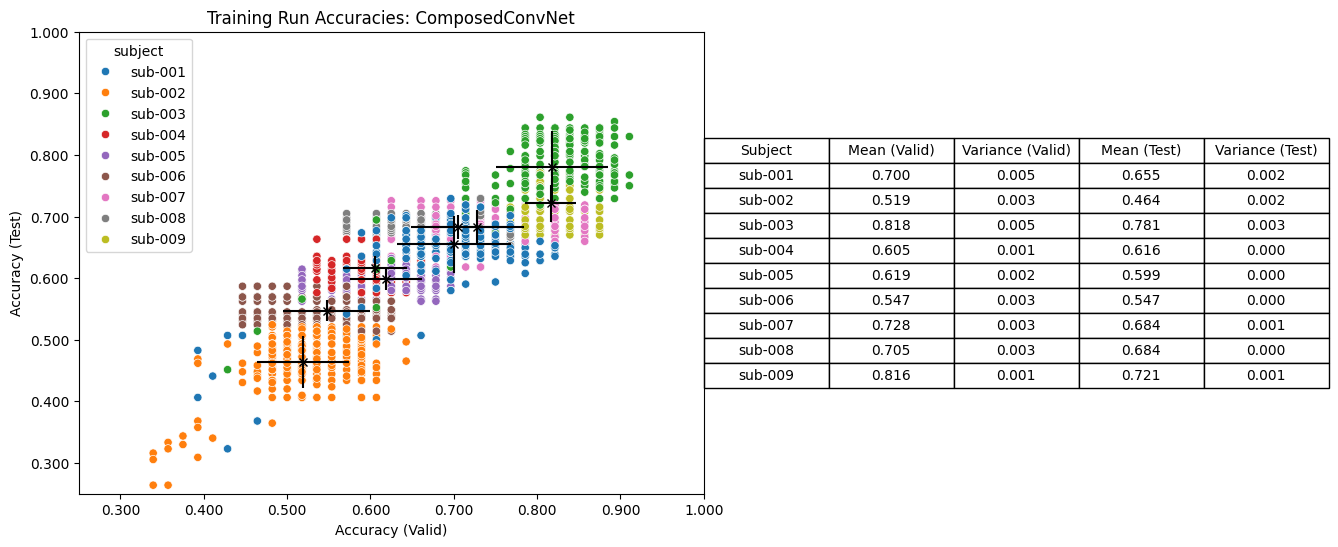

In [51]:
plot_subject_accuracies(path='/workspace/results/ComposedConvNet', modelname='ComposedConvNet')

### Best Model Hyperparameters
- cnn_temporal_kernels_growth: 26
- cnn_temporal_kernelsize: 7
- cnn_num_temporal_layers: 4
- cnn_spatial_kernels_growth: 6
- cnn_num_spatial_layers: 2
- cnn_poolsize_: 10
- cnn_poolstride_: 9
- cnn_poolsize: 40
- cnn_poolstride: 36
- dropout: 0.07433 

### Best Data Augmentation Hyperparameters
- amp_delta: 0.4981
- max_num_segments: 3
- snr_white_delta: 5.09
- snr_white_low: 8.7 

### Parameters

Total params: 291,636

### Comments
While 64% accuracy is a promising result for a first attempt, it is nonetheless lower than the original ShallowConvNet benchmark of about 69% accuracy. As the depth of each convolutional block was parameterized through hyperparameter search, it does seem somewhat odd for the model to settle at 4 temporal blocks (options: {3, 4, 5}) and especially 2 spacial blocks (options{1, 2, 3}). \
We have a hint that the model did in fact settle for a more compositional approach to temporal convolution, as the tuned optimal kernel size for this model is half (7, 1) the optimal kernel size included in the best hyperparams for ShallowConvNet (14, 1), but the former's receptive field is almost double, at (25, 1). \
The main problem at hand with this model is its number of parameters. While not completely disproportionate, models for motor imagery tasks, and with the amount of data at hand, typically have parameters in the tens of thousands.

# DenseConvNet
---
Considering the results from the previous experiment, I saw little interest in modifying the original spatial convolution from the ShallowConvNet, but wanted to further the idea of extracting patterns at multiple scales from the temporal axis. As such, I tried to implement a densely connected convolutional block focusing on the data's temporal axis. \
DenseNets come with a number of risks, however, such as an exploding number of parameters and overfitting. In an attempt to prevent overfitting, I have implemented a dropout layer inside of each of the dense block's components (not to be confused with the densely connwected layer at the end), inspired by an experiment introduced in [Reconciling Feature-Reuse and Overfitting in DenseNet with Specialized Dropout](https://doi.org/10.48550/arXiv.1810.00091). In the paper, they specify a specific dropout rate for interlayer connections, increasing with the distance between layers as to prevent overfitting to features from the initial layer and encouraging a compositional approach to convolutional layer. I have implemented a simpler version of this, based upon the idea that implementing the dropout within the block itself, paired with concatenation of input and output, effectively creates a growing dropout that follows $$ dropout_{layer}=\sum_{}^{L}p*\prod_{l=1}^{L}(1-lp) $$ for each layer, where \
***L=total number of layers between concerned layer and final one of the dense block \
p=intralayer dropout*** \
\
In order to limit the size of output of the dense block, a 1x1, depthwise convolution tries to sift salient features and reduce the overall tensor size by a learned parameterized ratio. \
The rest of the network remains unchanged from the initial ShallowConvNet implementation, as it seems quite efficient for the given task.

## Implementation

In [3]:
%%writefile /workspace/content/benchmarks/benchmarks/MOABB/models/DenseConvNet.py

"""DenseConvNet
Attempt to turn the temporal convolutional layer into a dense convolutional block for
ShallowConvNet from https://doi.org/10.1002/hbm.23730, using a dropout technique for
DenseNets taken from https://doi.org/10.48550/arXiv.1810.00091.

Authors
 * Thomas Wolfgang Peschlow, 2024
"""

import torch
import speechbrain as sb
import numpy as np

class ConvModule(torch.nn.ModuleDict):
    """ConvModule.

    Arguments
    ---------
    in_channels : int
        Size of the input tensor's channel axis.
    out_channels: int
        Size of the output tensor's channel axis.
    kernel_size: tuple(int)
        Size of the convolutional kernel.
    dropout: float
        Dropout probability.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 dropout):
        super().__init__()

        self.add_module(
                "conv",
                sb.nnet.CNN.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding="same",
                    bias=True,
                    swap=True,
                ),
            )        
        self.add_module(
                "act",
                torch.nn.ReLU()
            )      
        self.add_module(
                "dropout",
                torch.nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.dropout(x)
        return x
            

class Square(torch.nn.Module):
    """Layer for squaring activations."""

    def forward(self, x):
        return torch.square(x)


class Log(torch.nn.Module):
    """Layer to compute log of activations."""

    def forward(self, x):
        return torch.log(torch.clamp(x, min=1e-6))


class DenseConvNet(torch.nn.Module):
    """ComposedConvNet.

    Arguments
    ---------
    num_classes: int
        Number of output neurons.
    input_shape : tuple
        The shape of the input.
    cnn_temporal_kernels_growth : int
        Number of additional kernels after every 2d temporal convolution.
    cnn_temporal_kernelsize : tuple
        Kernel size of the 2d temporal convolution.
    cnn_num_temporal_layers: int
        number of temporal convolutional layers in the dense block.
    cnn_spatial_growth_factor: float
        Number of output channels from the spatial convolution, proportional to input channels.
    cnn_poolsize: tuple
        Pool size.
    cnn_poolstride: tuple
        Pool stride.
    cnn_pool_type: string
        Pooling type.
    cnn_dense_compression_ratio: float
        Number of output channels from the 1x1 depthwise convolution, proportional to input channels.
    dense_dropout: float
        Dropout probability in dense block.
    dropout: float
        Dropout probability for post-dense layers.

    Example
    -------
    >>> inp_tensor = torch.rand([1, 200, 32, 1])
    >>> model = ShallowConvNet(input_shape=inp_tensor.shape)
    >>> output = model(inp_tensor)
    >>> output.shape
    torch.Size([1,4])
    """

    def __init__(
        self,
        num_classes,
        input_shape=None,
        cnn_temporal_kernels_growth=8,
        cnn_temporal_kernelsize=(25, 1),
        cnn_num_temporal_layers=3,
        cnn_spatial_growth_factor=1.,
        cnn_poolsize=(38, 1),
        cnn_poolstride=(8, 1),
        cnn_pool_type="avg",
        cnn_dense_compression_ratio=0.25,
        dense_dropout=0.1,
        dropout = 0.25
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        self.default_sf = 250  # sampling rate of the original publication (Hz)

        if not cnn_temporal_kernelsize[0]%2:
            cnn_temporal_kernelsize = (cnn_temporal_kernelsize[0]+1, 1)

        # T = input_shape[1]
        C = input_shape[2]

        inp = [torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))]
        self.temporal_module = torch.nn.Sequential()
        growth = 0
        in_size = 0
        for i in range(cnn_num_temporal_layers):
            print(i)
            print([input.shape for input in inp])
            in_size = torch.cat(inp, -1).shape[-1]
            growth += cnn_temporal_kernels_growth
            out_size = in_size+growth
            # Temporal convolution
            conv = ConvModule(in_channels=max(1, in_size),
                           out_channels=out_size,
                           kernel_size=cnn_temporal_kernelsize,
                           dropout=dense_dropout)
            self.temporal_module.add_module(
                f"conv{i}",
                conv
            )
            inp.append(conv(torch.cat(inp, -1)))

        self.compression_module = torch.nn.Sequential()

        in_size = torch.cat(inp, -1).shape[-1]
        out_size = int(cnn_dense_compression_ratio*in_size)

        self.compression_module.add_module(
            "bnorm",
            sb.nnet.normalization.BatchNorm2d(
                input_size=in_size, momentum=0.1, affine=True,
            ),
        )

        self.compression_module.add_module(
            "conv",
            sb.nnet.CNN.Conv2d(
                    in_channels=in_size,
                    out_channels=out_size,
                    kernel_size=(1, 1),
                    padding="valid",
                    bias=False,
                    swap=True,
                )
        )
            
        in_size = out_size
        out_size = int(in_size*cnn_spatial_growth_factor)

        #SPATIAL MODULE
        self.spatial_module = torch.nn.Sequential()
            # Spatial convolution
        self.spatial_module.add_module(
              f"conv",
              sb.nnet.CNN.Conv2d(
                  in_channels=in_size,
                  out_channels=out_size,
                  kernel_size=(1, C),
                  padding="valid",
                  bias=False,
                  swap=True,
              ),
          )
        
        in_size = out_size

        self.transition_module = torch.nn.Sequential()

        self.transition_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=in_size, momentum=0.1, affine=True,
            ),
        )
        # Square-pool-log-dropout
        # conv non-lin
        self.transition_module.add_module(
            "square_1", Square(),
        )
        self.transition_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_poolsize,
                stride=cnn_poolstride,
                pool_axis=[1, 2],
            ),
        )
        # pool non-lin
        self.transition_module.add_module(
            "log_1", Log(),
        )
        self.transition_module.add_module(
            "dropout_1", torch.nn.Dropout(p=dropout),
        )

        # Shape of intermediate feature maps
        out = self.compression_module(torch.cat(inp, -1))
        out = self.spatial_module(out)
        out = self.transition_module(out)
        dense_input_size = torch.numel(out)

        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size, n_neurons=num_classes,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = [x]
        for layer in self.temporal_module:
            x.append(layer(torch.cat(x, -1)))
        x = torch.cat(x, -1)
        x = self.compression_module(x)
        x = self.spatial_module(x)
        x = self.transition_module(x)
        x = self.dense_module(x)
        return x

Writing /workspace/content/benchmarks/benchmarks/MOABB/models/DenseConvNet.py


## Hyperparameters

In [9]:
%%writefile /workspace/content/DenseConvNet.yaml

seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.11 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 50.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 1 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 881 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 6 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.008079 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 25 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 5.49 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>

# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels_growth: 8 # @orion_step1: --cnn_temporal_kernels_growth~"uniform(2, 12,discrete=True)"
cnn_temporal_kernelsize: 5 # @orion_step1: --cnn_temporal_kernelsize~"uniform(3, 13,discrete=True)"
cnn_num_temporal_layers: 3 # @orion_step1: --cnn_num_temporal_layers~"uniform(3, 4,discrete=True)"
cnn_spatial_growth_factor: 0.5 # @orion_step1: --cnn_spatial_growth_factor~"uniform(0.125, 1.25)"
cnn_poolsize_: 9 # @orion_step1: --cnn_poolsize_~"uniform(1, 10,discrete=True)"
cnn_poolstride_: 9 # @orion_step1: --cnn_poolstride_~"uniform(1, 10,discrete=True)"
# pool size / stride from 4/125 ms to 40/125 ms = circa 30 ms
cnn_poolsize: !ref <cnn_poolsize_> * 4 # same resolution as for EEGNet research space
cnn_poolstride: !ref <cnn_poolstride_> * 4 # same resolution as for EEGNet research space
cnn_dense_compression_ratio: 0.25 # @orion_step1: --cnn_dense_compression_ratio~"uniform(0.04, 0.5)"
dense_dropout: 0.1 # @orion_step1: --dense_dropout~"uniform(0.05, 0.25)"
dropout: 0.25 # @orion_step1: --dropout~"uniform(0.1, 0.5)"

model: !new:models.DenseConvNet.DenseConvNet
    num_classes: !ref <n_classes>
    input_shape: !ref <input_shape>
    cnn_temporal_kernels_growth: !ref <cnn_temporal_kernels_growth>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_num_temporal_layers: !ref <cnn_num_temporal_layers>
    cnn_spatial_growth_factor: !ref <cnn_spatial_growth_factor>
    cnn_poolsize: [!ref <cnn_poolsize>, 1]
    cnn_poolstride: [!ref <cnn_poolstride>, 1]
    cnn_dense_compression_ratio: !ref <cnn_dense_compression_ratio>
    dense_dropout: !ref <dense_dropout>
    dropout: !ref <dropout>

Overwriting /workspace/content/DenseConvNet.yaml


## Training/Hyperparameter Tuning

In [10]:
%%capture
!mkdir -p /content/results/DenseConvNet
!./run_hparam_optimization.sh --exp_name 'DenseNet_BNCI2014001_hopt' \
                             --output_folder /workspace/content/results/DenseConvNet \
                             --data_folder eeg_data/ \
                             --hparams /workspace/content/DenseConvNet.yaml \
                             --nsbj 9 --nsess 2 \
                             --nsbj_hpsearch 2 --nsess_hpsearch 1 \
                             --nruns 1 \
                             --nruns_eval 5 \
                             --eval_metric acc \
                             --train_mode leave-one-session-out \
                             --exp_max_trials 20

## Analysis

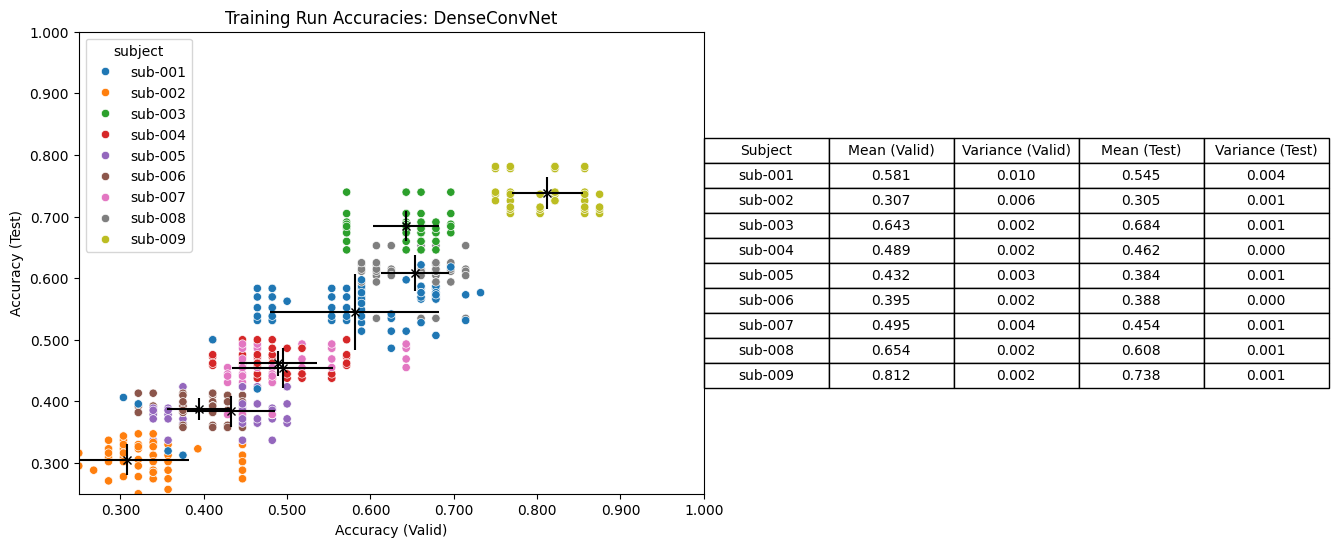

In [52]:
plot_subject_accuracies(path='/workspace/results/DenseConvNet', modelname='DenseConvNet')

### Best Model Hyperparameters
- cnn_temporal_kernels_growth: 9
- cnn_temporal_kernelsize: 5
- cnn_num_temporal_layers: 4
- cnn_spatial_growth_factor: 0.8128
- cnn_poolsize: 40
- cnn_poolstride: 12
- cnn_dense_compression_ratio: 0.1421
- dense_dropout: 0.1028
- dropout: 0.3018

### Best Data Augmentation Hyperparameters
- amp_delta:0.05499
- max_num_segments: 3
- snr_white_delta: 8.33
- snr_white_low: 10.0

### Parameters
- 125,581

### Comments
Unfortunately, performance is greatly reduced in this experiment, dropping to 50% accuracy. One of the main challenges during hyperparameter tuning was avoiding and controlling the size of the model, as some hyperparameter combinations, especially ones that included more layers in the dense block, could shoot up to 3 million parameters. However, a moderate channels growth per convolution(9) and a very small post-dense compression ratio (0.1421) seem to have mitigated the risk, yielding a realistic 125,581 parameters for the best model. However, such a bottleneck may as well be one of the biggest deterrents to the efficiency of the dense block, perhaps letting too little information pass.

# DenseConvNet-S
---
Although the results from DenseConvNet were no good, they weren't completely irredeemable either. As such, I tried anew to use DenseNets to address the problem at hand, but this time looking around for different convolutional methods. I was intrigued by [EEGInception](https://doi.org/10.48550/arXiv.2101.10932)'s interpretation of a seminal computer vision architecture, [GoogLeNet](https://doi.org/10.48550/arXiv.1409.4842), which had introduced the concept of inception modules. I decided to study recent work based on inception modules, and after stumbling upon François Chollet's [Xception Modules](https://doi.org/10.48550/arXiv.1610.02357), found a related paper: [An effective image classification method for shallow densely connected convolution networks through squeezing and splitting techniques](https://link.springer.com/article/10.1007/s10489-019-01468-7), in which they introduce DenseNet-S, and the Fire module. \
In short, the paper introduces a dense block in which individual convolutional blocks (Fire modules) are composed of a "squeezing" 1x1, depthwise convolution reducing the input channel size, followed by batch normalization and a ReLU activation, and finally the concatenation of parallel 2d convolutional layers of growing kernel size (x, x), each separated into two parallel convolutions of kernel size (x, 1) and (1, x). The paper argues that such growing and squeezing of features extracted at different scales helps create a low-parameter model with a great variety witrhin the nature and scale of learned parameters. \
Implementing square kernels makes a lot of sense within the context of categorizing images, but EEG data is much larger on the temporal axis (500, 22). As such, I have modified the kernel pairs to compensate for this axis imbalance. It just so happens that the size of the spatial axis (22) is approximately the square root of the size of the temporal axis (500^(0.5)=22.36), which led to the following kernel sizes:
$$(1, i+3), ((i+3)^2, 1)$$ where \
***i=kernel index={0, ..., N-1} \
N=number of parallel kernels in a convolutional block*** \
\
In this context, ***N*** was parameterized for hyperparameter search, with the goal of elucidating whether depth (more layers in the dense block) or width(more parallel convolutions in a convolutional block) would be more beneficial for learning. \
As the temporal and spatial convolutions were now done together, a simple 1x1 depthwise convolution was done after the dense block instead of ShallowConvNet's typical spatial convolution before passing through the final layers, unchanged from ShallowConvNet,

## Implementation

In [22]:
%%writefile /workspace/content/benchmarks/benchmarks/MOABB/models/DenseConvNet_S.py
"""DenseConvNet-S.
densely connected convolutional neural network based on the fire module introduced in https://link.springer.com/article/10.1007/s10489-019-01468-7,
and the end of network processing of ShallowConvNet from https://doi.org/10.1002/hbm.23730.

Authors
 * Thomas Wolfgang Peschlow, 2024
"""
import torch
import speechbrain as sb
import numpy as np

class FireModule(torch.nn.ModuleDict):
    """Fire Module.
    Adapted for EEG data from the implementation in https://link.springer.com/article/10.1007/s10489-019-01468-7.

    Arguments
    ---------
    in_channels: int
        size of the channel dimension of the input.
    squeeze_factor: float
        factor by which the size of the channel dimension is multiplied (generally reduced) after the initial squeezing convolution.
    conv_out_channels: int
        Number of output channels for each parallel convolution, prior to concatenation.
    num_convs: int
        Number of pairs of parallel convolutions.
    """

    def __init__(self,
                 in_channels,
                 squeeze_factor,
                 conv_out_channels,
                 num_convs):
      
        super().__init__()

        squeezed_channels = max(int(in_channels*squeeze_factor), 1)

        self.bn = sb.nnet.normalization.BatchNorm2d(
                    input_size=in_channels,
                    momentum=0.1,
                    affine=True)
        
        self.relu = torch.nn.ReLU()

        self.init_conv = sb.nnet.CNN.Conv2d(
                    in_channels=in_channels,
                    out_channels=squeezed_channels,
                    kernel_size=(1, 1),
                    padding="same",
                    bias=True,
                    swap=True)
        
        self.parallel_module = torch.nn.Sequential()
        for i in range(num_convs):

            spatial_size = i*2+3

            temp_conv = sb.nnet.CNN.Conv2d(
                    in_channels=squeezed_channels,
                    out_channels=conv_out_channels,
                    kernel_size=(spatial_size**2, 1),
                    padding="same",
                    bias=True,
                    swap=True)
            self.parallel_module.add_module(f"temp{i}", temp_conv)

            spatial_conv = sb.nnet.CNN.Conv2d(
                    in_channels=squeezed_channels,
                    out_channels=conv_out_channels,
                    kernel_size=(1, spatial_size),
                    padding="same",
                    bias=True,
                    swap=True)
            self.parallel_module.add_module(f"spatial{i}", spatial_conv)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.init_conv(x)
        convs = []
        for layer in self.parallel_module:
            convs.append(layer(x))
        return torch.cat(convs, -1)


class Squaree(torch.nn.Module):
    """Layer for squaring activations."""

    def forward(self, x):
        return torch.square(x)


class Logg(torch.nn.Module):
    """Layer to compute log of activations."""

    def forward(self, x):
        return torch.log(torch.clamp(x, min=1e-6))


class DenseConvNet_S(torch.nn.Module):
    """DenseConvNet-S.

    Arguments
    ---------
    num_classes: int
        Number of output neurons.
    input_shape : tuple
        The shape of the input.
    cnn_num_conv_layers : int
        Number of Fire Modules in the dense block.
    cnn_num_parallel_convs : int
        Number of pairs of parallel convolutions in a Fire Module.
    cnn_conv_squeeze_factor : float
        factor by which the size of the channel dimension is multiplied (generally reduced) after the initial squeezing convolution in the Fire Module.
    cnn_poolsize: tuple
        Pool size.
    cnn_poolstride: tuple
        Pool stride.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.

    Example
    -------
    >>> inp_tensor = torch.rand([1, 200, 32, 1])
    >>> model = ShallowConvNet(input_shape=inp_tensor.shape)
    >>> output = model(inp_tensor)
    >>> output.shape
    torch.Size([1,4])
    """

    def __init__(
        self,
        num_classes=None,
        input_shape=None,
        cnn_num_conv_layers=3,
        cnn_num_parallel_convs=2,
        cnn_conv_squeeze_factor=0.25,
        cnn_kernels_growth=8,
        cnn_poolsize=(38, 1),
        cnn_poolstride=(8, 1),
        cnn_pool_type="avg",
        dropout = 0.25
    ):
        super().__init__()

        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if num_classes is None:
            raise ValueError("Must specify num_classes")
        self.default_sf = 250  # sampling rate of the original publication (Hz)

        # T = input_shape[1]
        C = input_shape[2]

        self.conv_module = torch.nn.Sequential()
        growth = 0
        in_size = 0
        inp = [torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))]

        for i in range(cnn_num_conv_layers):
            
            #print([input.shape for input in inp]) #useful for debugging, densenets are hard to get right
            in_size = torch.cat(inp, -1).shape[-1]
            out_size = in_size+cnn_kernels_growth

            # Separated, parallel convolution
            conv = FireModule(in_channels=max(1, in_size),
                              squeeze_factor=cnn_conv_squeeze_factor,
                              conv_out_channels=out_size,
                              num_convs=cnn_num_parallel_convs)
            
            self.conv_module.add_module(f"conv{i}", conv)
            inp.append(conv(torch.cat(inp, -1)))

        in_size = torch.cat(inp, -1).shape[-1]

        out_size = int(in_size*cnn_conv_squeeze_factor)

        self.transition_module = torch.nn.Sequential()

        self.transition_module.add_module(
            "conv",
            sb.nnet.CNN.Conv2d(
                    in_channels=in_size,
                    out_channels=out_size,
                    kernel_size=(1, 1),
                    padding="same",
                    bias=True,
                    swap=True)
        )

        in_size = out_size

        self.transition_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=in_size, momentum=0.1, affine=True,
            ),
        )

        # Square-pool-log-dropout
        self.transition_module.add_module(
            "square_1", Squaree(),
        )
        self.transition_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_poolsize,
                stride=cnn_poolstride,
                pool_axis=[1, 2],
            ),
        )
        # pool non-lin
        self.transition_module.add_module(
            "log_1", Logg(),
        )
        self.transition_module.add_module(
            "dropout_1", torch.nn.Dropout(p=dropout),
        )

        # Shape of intermediate feature maps
        out = self.transition_module(torch.cat(inp, -1))
        dense_input_size = torch.numel(out)

        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size, n_neurons=num_classes,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = [x]
        for layer in self.conv_module:
            x.append(layer(torch.cat(x, -1)))
        x = torch.cat(x, -1)
        x = self.transition_module(x)
        x = self.dense_module(x)
        return x

Overwriting /workspace/content/benchmarks/benchmarks/MOABB/models/DenseConvNet_S.py


## Hyperparameters

In [26]:
%%writefile /workspace/content/DenseConvNet_S.yaml

seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.11 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 50.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 1 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 447 # @orion_step1: --number_of_epochs~"uniform(250, 800, discrete=True)"
lr: 0.001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 6 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.008079 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 25 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 5.49 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>

# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_num_conv_layers: 3
cnn_num_parallel_convs: 2
cnn_conv_squeeze_factor: 0.04 # @orion_step1: --cnn_conv_squeeze_factor~"uniform(0.01, 0.125)"
cnn_kernels_growth: 4 # @orion_step1: --cnn_kernels_growth~"uniform(4, 16,discrete=True)"
cnn_poolsize_: 12 # @orion_step1: --cnn_poolsize_~"uniform(1, 20,discrete=True)"
cnn_poolstride_: 12 # @orion_step1: --cnn_poolstride_~"uniform(1, 20,discrete=True)"
# pool size / stride from 4/125 ms to 40/125 ms = circa 30 ms
cnn_poolsize: !ref <cnn_poolsize_> * 4 # same resolution as for EEGNet research space
cnn_poolstride: !ref <cnn_poolstride_> * 4 # same resolution as for EEGNet research space
dropout: 0.25 # @orion_step1: --dropout~"uniform(0.1, 0.5)"

model: !new:models.DenseConvNet_S.DenseConvNet_S
    num_classes: !ref <n_classes>
    input_shape: !ref <input_shape>
    cnn_num_conv_layers: !ref <cnn_num_conv_layers>
    cnn_num_parallel_convs: !ref <cnn_num_parallel_convs>
    cnn_conv_squeeze_factor: !ref <cnn_conv_squeeze_factor>
    cnn_kernels_growth: !ref <cnn_kernels_growth>
    cnn_poolsize: [!ref <cnn_poolsize>, 1]
    cnn_poolstride: [!ref <cnn_poolstride>, 1]
    dropout: !ref <dropout>

Overwriting /workspace/content/DenseConvNet_S.yaml


## Training and Hyperparameter Optimization

In [ ]:
%%capture
!mkdir -p /workspace/content/results/DenseConvNet_S
!./run_hparam_optimization.sh --exp_name 'DenseNet_S_BNCI2014001_hopt' \
                             --output_folder /workspace/content/results/DenseConvNet_S \
                             --data_folder eeg_data/ \
                             --hparams /workspace/content/DenseConvNet_S.yaml \
                             --nsbj 9 --nsess 2 \
                             --nsbj_hpsearch 2 --nsess_hpsearch 2 \
                             --nruns 1 \
                             --nruns_eval 5 \
                             --eval_metric acc \
                             --train_mode leave-one-session-out \
                             --exp_max_trials 20

## Analysis

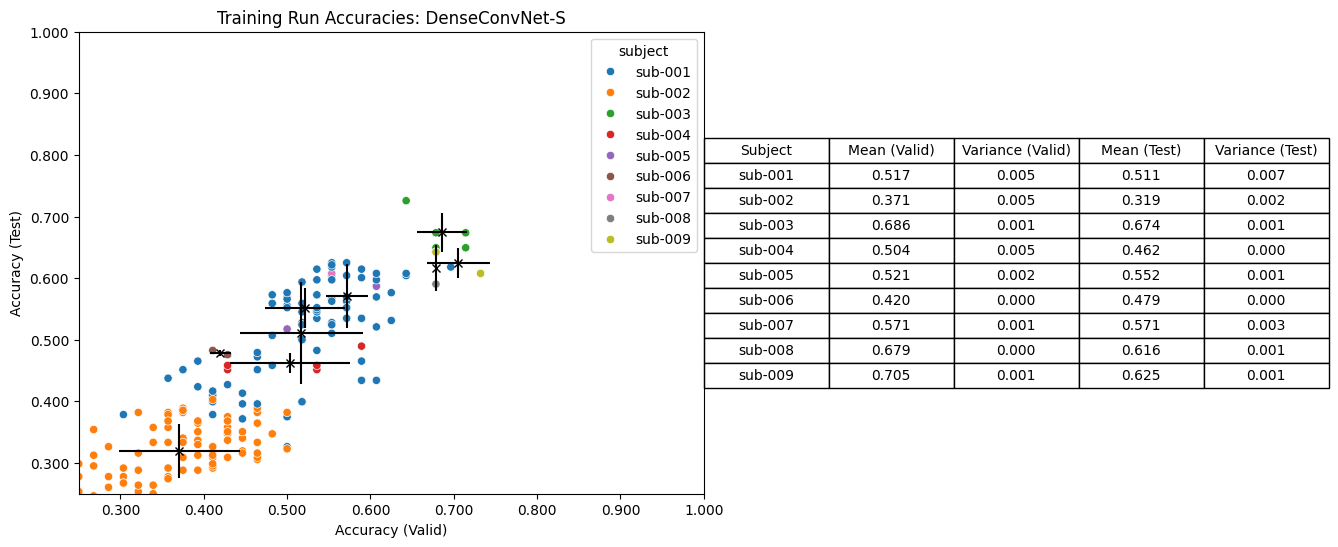

In [3]:
plot_subject_accuracies(path='/workspace/results/DenseConvNet_S', modelname='DenseConvNet-S')

### Best Model Hyperparameters
- cnn_num_conv_layers: 3
- cnn_num_parallel_convs: 2
- cnn_conv_squeeze_factor: 0.1021
- cnn_kernels_growth: 3
- cnn_poolsize_: 68
- cnn_poolstride_: 56
- dropout: 0.4631
### Best Data Augmentation Hyperparameters
- max_num_segments: 2
- amp_delta: 0.05772
- snr_white_low: 12.0
- snr_white_delta: 5.42
### Parameters
1,057,126
### Comments
Despite the hyperparameter tuning defining 3 Fire Modules as the best option within the dense block, the exponential growth of parameters within the dense block are too much for the aggressive squeezing factor (0.1021) and extremely large pooling stride (56) to even compensate, yielding an excessive 1,057,126 parameters for the "best" model. \
Given similar results to the previous experiment, it is hard to gauge whether the Fire Module was of any use, but taking into consideration that 1M paraameters is way took many for such data and is most likely causing problems related to overfitting, it may still have potential application in another architecture or context.

# ComposedConvNet-S
---
Given the lackluster results of my DenseNet experiments, I thought it would be worth trying to implement the previously defined Fire Module sequentially, as the sequential, compositional approach to convolutional learning has shown more promise in the first experiment. \
Since the channel dimension will not be growing nearly as fast than it was in the dense implementation, "squeezing" convolutions can be somewhat relaxed, with values closer to 0.5, halving the channel dimension instead of previous values hovering 0.1. This also opens up the opportunity for more parallel convolutions with which we can experiment with. Due to the presence of parallel convolutions, however, it may not be worth it to make a very deep network, capping the  depth of the sequential block to 3.

## Implementation

In [ ]:
%%writefile /workspace/content/benchmarks/benchmarks/MOABB/models/ComposedConvNet_S.py
"""ComposedConvNet-S.
Convolutional neural network based on the Fire Module introduced by https://link.springer.com/article/10.1007/s10489-019-01468-7,
implemented in a sequential rather than dense with the end of network processing of ShallowConvNet from https://doi.org/10.1002/hbm.23730.

Authors
 * Thomas Wolfgang Peschlow, 2024
"""
import torch
import speechbrain as sb
import numpy as np

class FireModule(torch.nn.ModuleDict):
    """Fire Module.
    Adapted for EEG data from the implementation in https://link.springer.com/article/10.1007/s10489-019-01468-7.

    Arguments
    ---------
    in_channels: int
        size of the channel dimension of the input.
    squeeze_factor: float
        factor by which the size of the channel dimension is multiplied (generally reduced) after the initial squeezing convolution.
    conv_out_channels: int
        Number of output channels for each parallel convolution, prior to concatenation.
    num_convs: int
        Number of pairs of parallel convolutions.
    """
    def __init__(self,
                 in_channels,
                 squeeze_factor,
                 conv_out_channels,
                 num_convs):

        super().__init__()

        squeezed_channels = max(int(in_channels*squeeze_factor), 1)

        self.bn = sb.nnet.normalization.BatchNorm2d(
                    input_size=in_channels,
                    momentum=0.1,
                    affine=True)

        self.relu = torch.nn.ReLU()

        self.init_conv = sb.nnet.CNN.Conv2d(
                    in_channels=in_channels,
                    out_channels=squeezed_channels,
                    kernel_size=(1, 1),
                    padding="same",
                    bias=True,
                    swap=True)

        self.parallel_module = torch.nn.Sequential()
        for i in range(num_convs):

            spatial_size = i*2+3

            temp_conv = sb.nnet.CNN.Conv2d(
                    in_channels=squeezed_channels,
                    out_channels=conv_out_channels,
                    kernel_size=(spatial_size**2, 1),
                    padding="same",
                    bias=True,
                    swap=True)
            self.parallel_module.add_module(f"temp{i}", temp_conv)

            spatial_conv = sb.nnet.CNN.Conv2d(
                    in_channels=squeezed_channels,
                    out_channels=conv_out_channels,
                    kernel_size=(1, spatial_size),
                    padding="same",
                    bias=True,
                    swap=True)
            self.parallel_module.add_module(f"spatial{i}", spatial_conv)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.init_conv(x)
        return torch.cat([layer(x) for layer in self.parallel_module], -1)


class Squaree(torch.nn.Module):
    """Layer for squaring activations."""

    def forward(self, x):
        return torch.square(x)


class Logg(torch.nn.Module):
    """Layer to compute log of activations."""

    def forward(self, x):
        return torch.log(torch.clamp(x, min=1e-6))


class ComposedConvNet_S(torch.nn.Module):
    """ComposedConvNet-S.

    Arguments
    ---------
    num_classes: int
        Number of output neurons.
    input_shape : tuple
        The shape of the input.
    cnn_num_conv_layers : int
        Number of Fire Modules in the dense block.
    cnn_num_parallel_convs : int
        Number of pairs of parallel convolutions in a Fire Module.
    cnn_conv_squeeze_factor : float
        factor by which the size of the channel dimension is multiplied (generally reduced) after the initial squeezing convolution in the Fire Module.
    cnn_kernels_growth : int
        Number of extra kernels per parallel convolution in the Fire Model, prior to concatenation.
    cnn_poolsize: tuple
        Pool size.
    cnn_poolstride: tuple
        Pool stride.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.

    Example
    -------
    >>> inp_tensor = torch.rand([1, 200, 32, 1])
    >>> model = ShallowConvNet(input_shape=inp_tensor.shape)
    >>> output = model(inp_tensor)
    >>> output.shape
    torch.Size([1,4])
    """

    def __init__(
        self,
        num_classes=None,
        input_shape=None,
        cnn_num_conv_layers=3,
        cnn_num_parallel_convs=2,
        cnn_conv_squeeze_factor=0.25,
        cnn_kernels_growth=8,
        cnn_poolsize=(38, 1),
        cnn_poolstride=(8, 1),
        cnn_pool_type="avg",
        dropout = 0.25
    ):
        super().__init__()

        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if num_classes is None:
            raise ValueError("Must specify num_classes")
        self.default_sf = 250  # sampling rate of the original publication (Hz)

        # T = input_shape[1]
        C = input_shape[2]

        self.conv_module = torch.nn.Sequential()
        in_size = 1
        out_size = in_size
        inp = torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))

        for i in range(cnn_num_conv_layers):

            in_size = inp.shape[-1]
            out_size += cnn_kernels_growth

            # Separated, parallel convolution
            conv = FireModule(in_channels=max(1, in_size),
                              squeeze_factor=cnn_conv_squeeze_factor,
                              conv_out_channels=out_size,
                              num_convs=cnn_num_parallel_convs)

            self.conv_module.add_module(f"conv{i}", conv)
            inp = conv(inp)

        in_size = inp.shape[-1]

        out_size = int(in_size*cnn_conv_squeeze_factor)

        self.transition_module = torch.nn.Sequential()

        self.transition_module.add_module(
            "conv",
            sb.nnet.CNN.Conv2d(
                    in_channels=in_size,
                    out_channels=out_size,
                    kernel_size=(1, 1),
                    padding="valid",
                    bias=True,
                    swap=True)
        )

        in_size = out_size

        self.transition_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=in_size, momentum=0.1, affine=True,
            ),
        )

        # Square-pool-log-dropout
        self.transition_module.add_module(
            "square_1", Squaree(),
        )
        self.transition_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_poolsize,
                stride=cnn_poolstride,
                pool_axis=[1, 2],
            ),
        )
        # pool non-lin
        self.transition_module.add_module(
            "log_1", Logg(),
        )
        self.transition_module.add_module(
            "dropout_1", torch.nn.Dropout(p=dropout),
        )

        # Shape of intermediate feature maps
        out = self.transition_module(inp)
        dense_input_size = torch.numel(out)

        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size, n_neurons=num_classes,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.transition_module(x)
        x = self.dense_module(x)
        return x

## Hyperparameters

In [9]:
%%writefile /workspace/content/ComposedConvNet_S.yaml

seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.11 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 50.0 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 2 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 1 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 447 # @orion_step1: --number_of_epochs~"uniform(250, 800, discrete=True)"
lr: 0.001 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 6 # @orion_step1: --batch_size_exponent~"uniform(4, 6,discrete=True)"
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.008079 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 25 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 15.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 5.49 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>

# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_num_conv_layers: 2
cnn_num_parallel_convs: 2
cnn_conv_squeeze_factor: 0.5 # @orion_step1: --cnn_conv_squeeze_factor~"uniform(0.25, 1.0)"
cnn_kernels_growth: 4 # @orion_step1: --cnn_kernels_growth~"uniform(2, 12,discrete=True)"
cnn_poolsize_: 12 # @orion_step1: --cnn_poolsize_~"uniform(1, 16,discrete=True)"
cnn_poolstride_: 12 # @orion_step1: --cnn_poolstride_~"uniform(1, 16,discrete=True)"
# pool size / stride from 4/125 ms to 40/125 ms = circa 30 ms
cnn_poolsize: !ref <cnn_poolsize_> * 4 # same resolution as for EEGNet research space
cnn_poolstride: !ref <cnn_poolstride_> * 4 # same resolution as for EEGNet research space
dropout: 0.25 # @orion_step1: --dropout~"uniform(0.1, 0.5)"

model: !new:models.ComposedConvNet_S.ComposedConvNet_S
    num_classes: !ref <n_classes>
    input_shape: !ref <input_shape>
    cnn_num_conv_layers: !ref <cnn_num_conv_layers>
    cnn_num_parallel_convs: !ref <cnn_num_parallel_convs>
    cnn_conv_squeeze_factor: !ref <cnn_conv_squeeze_factor>
    cnn_kernels_growth: !ref <cnn_kernels_growth>
    cnn_poolsize: [!ref <cnn_poolsize>, 1]
    cnn_poolstride: [!ref <cnn_poolstride>, 1]
    dropout: !ref <dropout>

Writing /workspace/content/ComposedConvNet_S.yaml


## Training/Hyperparameter Tuning

In [ ]:
%%capture
!mkdir -p /workspace/content/results/ComposedConvNet_S
!./run_hparam_optimization.sh --exp_name 'ComposedConvNet_S_BNCI2014001_hopt' \
                             --output_folder /workspace/content/results/ComposedConvNet_S \
                             --data_folder eeg_data/ \
                             --hparams /workspace/content/ComposedConvNet_S.yaml \
                             --nsbj 9 --nsess 2 \
                             --nsbj_hpsearch 2 --nsess_hpsearch 1 \
                             --nruns 1 \
                             --nruns_eval 5 \
                             --eval_metric acc \
                             --train_mode leave-one-session-out \
                             --exp_max_trials 12

## Analysis

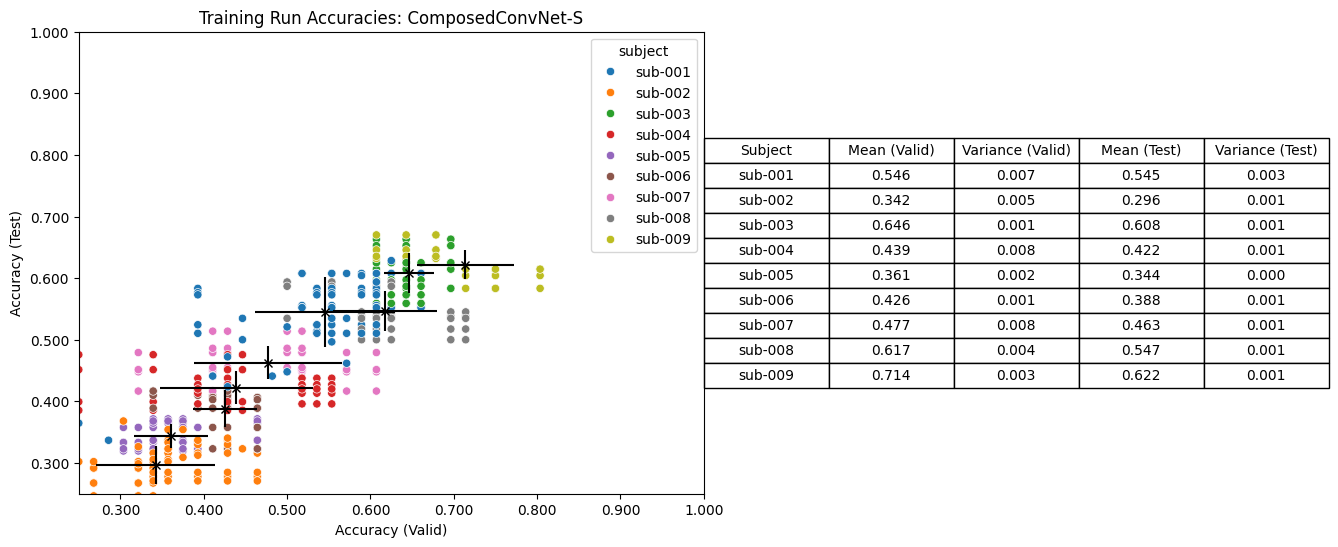

In [54]:
plot_subject_accuracies(path='/workspace/results/ComposedConvNet_S', modelname='ComposedConvNet-S')

### Best Model Hyperparameters
- cnn_num_conv_layers: 2
- cnn_num_parallel_convs: 2
- cnn_conv_squeeze_factor: 0.3607
- cnn_kernels_growth: 3
- cnn_poolsize_: 60
- cnn_poolstride_: 24
- dropout: 0.1055
### Best Data Augmentation Hyperparameters
- max_num_segments: 3
- amp_delta: 0.2982
- snr_white_low: 4.9
- snr_white_delta: 9.55
### Parameters
15,317
### Comments
Results remain similar to the previous approach despite yielding a much lighter model (15, 317 parameters instead of 1M+). While this is a bit more promising, as it leaves space for additions and tweaking, the final result is still pretty bad. 

# Conclusion
---
This project has been an important personal stepping stone into the world of machine learning, where I got to delve into the field's litterature, theory, and practice. It has given me the tools to start further personal exploration into the subject with a solid technical base to build upon. That being said, only 1 of the 4 experiments has yielded results relatively close to the state of the art, and it is also the one that was the least altered (ComposedConvNet). From my experiments, I am ablew to extract a few conclusions, premonitions, or intuitions.

- Most ideas introduced in this project were borrowed from the field of computer vision, especially from image classification tasks. While the data may look somewhat similar, their respective underlying structures seem to be very different. On one hand, computer vision tasks seem to benefit from deeper networks due to the compositionality it offers, detecting different patterns at different scales that all encode different information on the image. EEG data does not seem to be structured as such.
- The EEG data used for the experiment, as expected with externally recorded EEG data, seems to suffer from a quite high noise to signal ratio. Furthermore, the nature of the data and the patterns that lie within it seems to be extremely dependent upon the recorded individual itself. This seems to limit the capacity a model designed for such a task at hand, as it can rapidly start fitting to noise or patient-centric peculiarities in the data, and also highlights the importance of batch normalization in the process.
- The best approaches seem to be as such mainly due to their understanding of the data itself and how to process it moreso than complicated machine learning architectures, both ShallowConvNet and EEGNet are extremely simple architectures.
- Referencing the previous point, I believe I should have made another adjustment to my Fire Module, used in DenseConvNet-S and ComposedConvNet-S. The final block, preserved from ShallowConvNet, passes the the data through a square and a log function. I assume the motivation for this is that magnitude is much more important than the actual sign of the data, hence the squaring, and the logarithm is simply to avoid overfitting through excessive weight values. In my Fire Module, I have implemented a ReLU layer, which makes any negative value 0. This may have simply removed a lot of salient data for subsequent layers in the process, as it actively opposes the main reason why one would implement that square and log function. Perhaps it would be worth trying a newe implementation of the Fire Module, but this time with either no activation function or a non-saturating one, perhaps it would be worth trying [Snake Activation](https://arxiv.org/pdf/2006.08195).